# Inference

This collab is designed to run inference using Video-LLaVA fine tuned with CinePile pulling the model from Hugging Face Hub [mfarre/Video-LLaVA-7B-hf-CinePile](https://huggingface.co/mfarre/Video-LLaVA-7B-hf-CinePile).

There are two ways to run it:
* On any video - given a YouTube link and closed captions
* On CinePile's test dataset

Inference script based on [CinePile's Colab Notebook](https://colab.research.google.com/drive/1jDwvPoCsg9tck3dFhVCV-h3Ny6992wCr?usp=sharing)

In [1]:
import os
import cv2
import shutil
import PIL
from PIL import Image
import pathlib
import matplotlib.pyplot as plt;
import torch
from transformers import VideoLlavaProcessor, VideoLlavaForConditionalGeneration, BitsAndBytesConfig
from peft import PeftModel
import subprocess
import numpy as np
from datasets import load_dataset

from scenedetect import VideoManager
from scenedetect import SceneManager
from scenedetect.detectors import ContentDetector
from scenedetect.scene_manager import save_images

/home/daniel/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

model_id = "LanguageBind/Video-LLaVA-7B-hf"
processor = VideoLlavaProcessor.from_pretrained(model_id)
model = VideoLlavaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    quantization_config=quantization_config,
    device_map="auto",
)
model = PeftModel.from_pretrained(model, "mfarre/Video-LLaVA-7B-hf-CinePile")

MAX_GENERATED_LENGTH = 256 

The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.
Loading checkpoint shards: 100%|██████████| 3/3 [00:12<00:00,  4.30s/it]


## Auxiliar functions
Mainly to handle video and extract inference frames from it.

In [3]:
def download_video(video_url, filename, root):
    """
    Download and convert a video from a URL and save it to a specified directory.

    Parameters:
    - video_url (str): The URL of the video to be downloaded.
    - filename (str): The base name for the output file, without file extension.
    - root (str): The root directory where the 'yt_videos' folder will be created.

    Returns:
    - tuple: A tuple containing the video URL and a boolean. The boolean is True if the
      download and conversion was successful, and False otherwise.
    """

    dir_path=f"{root}/yt_videos"

    try:
        vid_prefix = os.path.join(dir_path, filename)
        full_command = [
            "yt-dlp",
            "-S",
            "height:224,ext:mp4:m4a",
            "--write-subs",
            "--recode",
            "mp4",
            "-o",
            f"{vid_prefix}.mp4",
            video_url
        ]

        print(f'saving path: {vid_prefix}.mp4')

        result = subprocess.run(full_command, capture_output=True, text=True)

        if result.returncode == 0:
            print(f"Downloaded: {vid_prefix}; {video_url}")
            return video_url, True
        else:
            print(f"Failed to download or convert {video_url}. Error: {result.stderr}")
            return video_url, False

    except Exception as e:
        print(f"Exception during download or conversion of {video_url}: {e}")
        return video_url, False

In [4]:
def find_scenes(video_path, threshold=30.0):
    """
    Detects important scenes in a video by analyzing changes between frames and identifying significant content changes that exceed a specified threshold.

    Parameters:
    video_path (str): The file path to the video file for which scenes are to be detected.
    threshold (float): The sensitivity threshold for detecting scene changes.

    Returns:
    list of tuples: A list where each tuple contains the start and end `FrameTimecodes` of a detected scene.
    """

    # Create a video manager object for the video.
    video_manager = VideoManager([video_path])
    scene_manager = SceneManager()

    # Add ContentDetector algorithm (with a threshold).
    scene_manager.add_detector(ContentDetector(threshold=threshold))

    # Start the video manager and perform scene detection.
    video_manager.set_downscale_factor()
    video_manager.start()

    # Perform scene detection and return scene list.
    scene_manager.detect_scenes(frame_source=video_manager)

    # Each scene is a tuple of (start, end) FrameTimecodes.
    return scene_manager.get_scene_list()

In [5]:
def save_frames_from_scenes(video_path, scenes, output_folder):
    """
    Extracts and saves the first frame from each detected scene in a video.

    Parameters:
    - video_path (str): The file path to the video from which frames are to be extracted.
    - scenes (list): A list of scene boundaries or metadata that specifies where each scene begins and ends.
    - output_folder (str): The directory path where the extracted frames should be saved.

    Returns:
    - None: The function saves the frames to the specified directory and does not return any value.
    """
    # Ensure output directory exists.
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Initialize video manager for frame extraction.
    video_manager = VideoManager([video_path])
    video_manager.start()

    # Save the first frame of each detected scene.
    save_images(scenes, video_manager, num_images=1, output_dir=output_folder, image_name_template='$SCENE_NUMBER')

    video_manager.release()

In [6]:
def get_uniform_frames(video_path, num_frames=10):
    """
    This function takes a video file and returns a list of uniform frames from the video.
    :param video_path: str, path to the video file
    :param num_frames: int, number of uniform frames to return

    :return: list of frames
    """
    # check if path exists
    if not os.path.exists(video_path):
        raise FileNotFoundError(f"Video file not found at {video_path}")
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    uniform_frames = np.linspace(0, total_frames-1, num_frames, dtype=int)  # picking n frames uniformly from the video
    # random_frames = random.sample(range(total_frames), num_frames)
    frames = []
    for frame_num in uniform_frames:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
        ret, frame = cap.read()
        if ret:
            frames.append(frame)
    return frames

def save_frames_as_jpg(frames, frames_dir):
    # create directory if it doesn't exist
    pathlib.Path(frames_dir).mkdir(parents=True, exist_ok=True)
    for i, frame in enumerate(frames):
        cv2.imwrite(f"{frames_dir}/{i}.jpg", frame)

In [7]:
def process_video(test_dataset, root_dir, base_folder_name='new_yt_videos', max_num_frames=10, visualize=False, ques_idx=None):
    if ques_idx is None:
        ques_idx = random.randint(0, len(test_dataset))
    print(ques_idx)
    data = test_dataset[ques_idx]
    clip_title, yt_link = data['yt_clip_title'], data['yt_clip_link']
    print(clip_title, yt_link)

    video_path = f"{root_dir}/{base_folder_name}/{data['movie_name']}_{yt_link.split('/')[-1]}.mp4"
    frames_dir = f"{root_dir}/{base_folder_name}_frames/_{data['movie_name']}_{yt_link.split('/')[-1]}"
    print(video_path)
    if not os.path.exists(video_path):
        download_video(yt_link, f"{data['movie_name']}_{yt_link.split('/')[-1]}", root=root_dir)
        scenes = find_scenes(video_path)
        save_frames_from_scenes(video_path, scenes, frames_dir)
    else:
        print("Skipping download, video exist")


    image_files = sorted([f for f in os.listdir(frames_dir) if f.endswith('.jpg')])[:-2]
    if len(image_files) < max_num_frames:
        shutil.rmtree(frames_dir)
        frames = get_uniform_frames(video_path, max_num_frames+2)[:-2]
        save_frames_as_jpg(frames, frames_dir)
        image_files = sorted([f for f in os.listdir(frames_dir) if f.endswith('.jpg')])

    img_file_paths = [os.path.join(frames_dir, image_file) for image_file in image_files]
    num_frames = max_num_frames if len(img_file_paths) > max_num_frames else len(img_file_paths)
    img_file_paths = [img_file_paths[i] for i in np.linspace(0, len(img_file_paths)-1, num_frames, dtype=int)]

    if visualize:
        num_cols = 5  # Number of columns in the grid
        num_rows = (num_frames + num_cols - 1) // num_cols  # Calculate the necessary number of rows to display all images

        fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))
        axs = axs.flatten() if num_frames > 1 else [axs]

        for i, img_path in enumerate(img_file_paths):
            img = Image.open(img_path)
            axs[i].imshow(img)
            axs[i].set_title(os.path.basename(img_path), fontsize=8)
            axs[i].axis('off')

        for ax in axs[len(img_file_paths):]:  # Hide unused axes
            ax.axis('off')

        plt.tight_layout()
        plt.show()

    return data, img_file_paths

In [8]:
def process_standalone_video(root_dir, yt_link, title, base_folder_name='new_yt_videos', max_num_frames=8, visualize=False):

    video_path = f"{root_dir}/{base_folder_name}/{title}_{yt_link.split('/')[-1]}.mp4"
    frames_dir = f"{root_dir}/{base_folder_name}_frames/_{title}_{yt_link.split('/')[-1]}"
    print(video_path)
    if not os.path.exists(video_path):
        download_video(yt_link, f"{title}_{yt_link.split('/')[-1]}", root=root_dir)
        scenes = find_scenes(video_path)
        save_frames_from_scenes(video_path, scenes, frames_dir)
    else:
        print("Skipping download, video exist")


    image_files = sorted([f for f in os.listdir(frames_dir) if f.endswith('.jpg')])[:-2]
    if len(image_files) < max_num_frames:
        shutil.rmtree(frames_dir)
        frames = get_uniform_frames(video_path, max_num_frames+2)[:-2]
        save_frames_as_jpg(frames, frames_dir)
        image_files = sorted([f for f in os.listdir(frames_dir) if f.endswith('.jpg')])

    img_file_paths = [os.path.join(frames_dir, image_file) for image_file in image_files]
    num_frames = max_num_frames if len(img_file_paths) > max_num_frames else len(img_file_paths)
    img_file_paths = [img_file_paths[i] for i in np.linspace(0, len(img_file_paths)-1, num_frames, dtype=int)]

    if visualize:
        num_cols = 5  # Number of columns in the grid
        num_rows = (num_frames + num_cols - 1) // num_cols  # Calculate the necessary number of rows to display all images

        fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))
        axs = axs.flatten() if num_frames > 1 else [axs]

        for i, img_path in enumerate(img_file_paths):
            img = Image.open(img_path)
            axs[i].imshow(img)
            axs[i].set_title(os.path.basename(img_path), fontsize=8)
            axs[i].axis('off')

        for ax in axs[len(img_file_paths):]:  # Hide unused axes
            ax.axis('off')

        plt.tight_layout()
        plt.show()

    return img_file_paths

# Inference on wild videos
Run this section for inference on a YouTube video of your choice
Note that the answers of the model have a strong bias towards the CinePile format. We clean it up to keep only the first sentence as it is usually where the value is.

In [11]:
# download_video("https://www.youtube.com/watch?v=IEGQfrpnjWk", "raptors-in-the-kitchen", 'cinepileevaldata')

saving path: cinepileevaldata/yt_videos/raptors-in-the-kitchen.mp4
Downloaded: cinepileevaldata/yt_videos/raptors-in-the-kitchen; https://www.youtube.com/watch?v=IEGQfrpnjWk


('https://www.youtube.com/watch?v=IEGQfrpnjWk', True)

cinepileevaldata/yt_videos/dune-palm-trees_Zwi0Bc1nRNQ?si=Ef5__3bN0ybNVZJF.mp4
Skipping download, video exist


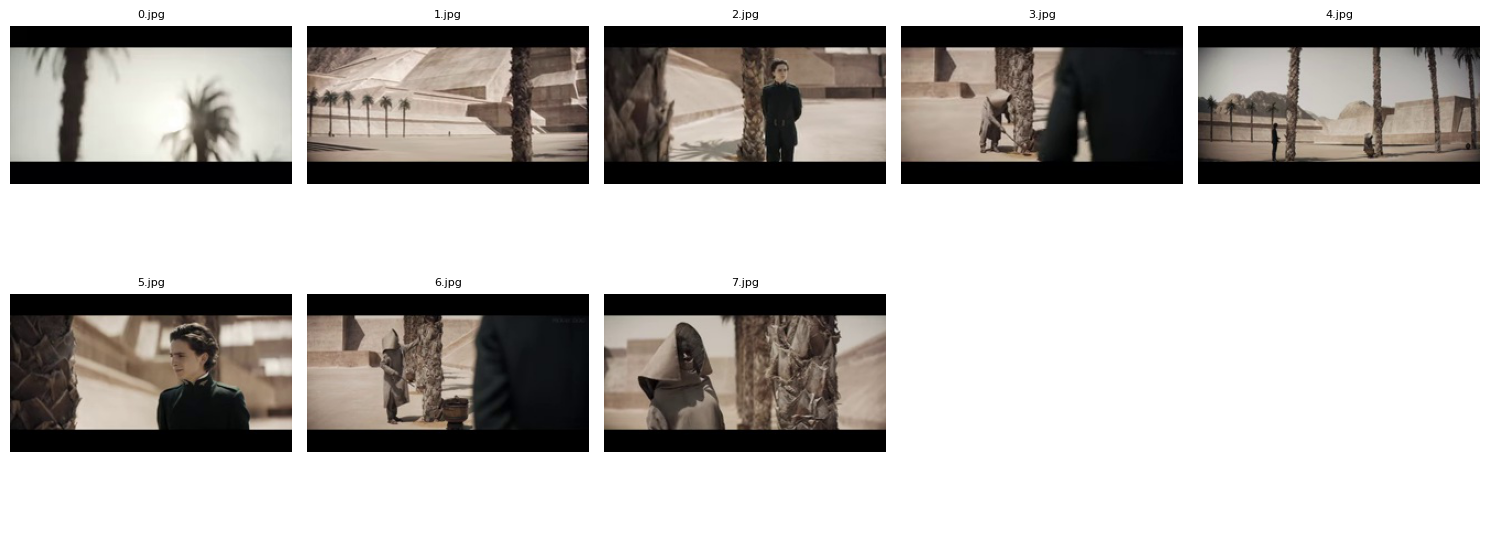

In [12]:
ROOT_DIR = 'cinepileevaldata'
video_link = "https://youtu.be/Zwi0Bc1nRNQ?si=Ef5__3bN0ybNVZJF"
own_title = "dune-palm-trees"
img_file_paths = process_standalone_video(ROOT_DIR, video_link, own_title , base_folder_name='yt_videos', max_num_frames=8, visualize=True)

Hand-made prompt. Note three important aspects: 
- It starts with `USER:` and ends with `ASSISTANT:`
- The `<video>` tag is necessary to insert the tokens from the video frames. It is placed between `USER:` and `ASSISTANT:`


In [13]:
prompt = """
"USER: <prompt>You will be provided with subtitles from a specific scene of a movie and a few frames from that scene. After going through the movie scene and seeing the frames, please answer the question that follows.

**Subtitles:** 
<subtitle> uh, hello
<subtitle> you should be out here this hour of the day
<subtitle> they're out here
<subtitle> framing pilgrims, they don't care about heat stroke
<subtitle> I doidn't know date palms could even be found out here
<subtitle> oh, these aren't indigenous, they can't survive without me
<subtitle> each one of these drinks every day the equivalent of five men
<subtitle> 20 palm trees, 100 lives
<subtitle> should we remove them save the water?
<subtitle> no no no these are sacred
<subtitle> old dream
<video>
Question: {question}

ASSISTANT:"""

In [14]:
formatted_prompt = prompt.format(question="What can you say about the environment's temperature in this scene?")

Loading the video and processing it together with the prompt


In [15]:
clip = np.stack([np.array((PIL.Image.open(f)).convert('RGB')) for f in img_file_paths])
inputs = processor(text=formatted_prompt, videos=clip, return_tensors="pt").to(model.device)


/home/daniel/miniconda3/envs/CinePile_p3.10/lib/python3.10/site-packages/transformers/feature_extraction_utils.py:142: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1720538440907/work/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(value)


Inference

In [16]:
# Generate token IDs and decode back into text
generated_ids = model.generate(**inputs, max_new_tokens=MAX_GENERATED_LENGTH)
generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)

# As the model is fine-tuned for CinePile, it might output too much noise on other tasks. Here we do a quick clean-up of the output.
print(generated_texts[0].split("ASSISTANT:")[1].split("\n")[0])

We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


OutOfMemoryError: CUDA out of memory. Tried to allocate 98.00 MiB. GPU 0 has a total capacity of 5.70 GiB of which 44.06 MiB is free. Process 2048 has 218.00 MiB memory in use. Including non-PyTorch memory, this process has 5.42 GiB memory in use. Of the allocated memory 4.96 GiB is allocated by PyTorch, and 324.09 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
formatted_prompt = prompt.format(question="How many 🚬 did he smoke?")

In [ ]:
clip = np.stack([np.array((PIL.Image.open(f)).convert('RGB')) for f in img_file_paths])
inputs = processor(text=formatted_prompt, videos=clip, return_tensors="pt").to(model.device)


In [ ]:
# Generate token IDs and decode back into text
generated_ids = model.generate(**inputs, max_new_tokens=MAX_GENERATED_LENGTH)
generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)

# As the model is fine-tuned for CinePile, it might output too much noise on other tasks. Here we do a quick clean-up of the output.
print(generated_texts[0].split("ASSISTANT:")[1].split("\n")[0])

# CinePile Evaluation
Parameters

In [ ]:
ROOT_DIR = 'cinepileevaldata'
MAX_LENGTH = 256
MAX_NUM_FRAMES = 10


Prompt formatting

In [ ]:
ans_key_map = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E'}
vision_and_language_dependence_prompt = '''USER: <prompt>You will be provided with subtitles from a specific scene of a movie and a few frames from that scene. After going through the movie scene and seeing the frames, please answer the question that follows. The question will have five possible answers labeled A, B, C, D, and E, please try to provide the most probable answer in your opinion. Your output should be just one of A,B,C,D,E and nothing else.

**Output Format:**
    **Answer:** <Option_key>

**Subtitles:** \n{subs}\n<video>\nQuestion: {question}

Note: Follow the output format strictly. Only answer with the option key (A, B, C, D, E) and nothing else.
ASSISTANT:'''

def format_question_and_options(question, options):
    """
    Formats a question and a list of options into a single string with options labeled A, B, C, etc.

    Parameters:
    - question (str): The question to be formatted.
    - options (list of str): The options for the question.

    Returns:
    - str: The formatted question and options.
    """
    formatted_string = f"{question}\n"
    option_labels = [chr(ord('A') + i) for i in range(len(options))]  # Generate option labels dynamically

    for label, option in zip(option_labels, options):
        formatted_string += f"- {label}) {option}\n"

    return formatted_string

def get_prompt(data):
    formatted_subs = data['subtitles']
    options = data['choices']
    formatted_question = format_question_and_options(data['question'], options)

    prompt = vision_and_language_dependence_prompt.format(subs=formatted_subs, question=formatted_question)
    return prompt

In [ ]:
cinepile = load_dataset("tomg-group-umd/cinepile")

We ran inference through all the clips

In [ ]:
results = []
for q in range(0,len(cinepile['test'])):
    data, img_file_paths = process_video(cinepile['test'], ROOT_DIR, base_folder_name='yt_videos', max_num_frames=MAX_NUM_FRAMES, visualize=False, ques_idx=q)
    prompt = get_prompt(data)
    clip = np.stack([np.array((PIL.Image.open(f)).convert('RGB')) for f in img_file_paths])
    inputs = processor(text=prompt, videos=clip, return_tensors="pt").to(model.device)
    generated_ids = model.generate(**inputs, max_new_tokens=MAX_LENGTH)
    generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)
    #answer = generated_texts[0][-1]
    answer = generated_texts[0].split("ASSISTANT:")[1][0]

    ans_key_opt = ans_key_map[data['answer_key_position']]
    correct = False
    if ans_key_opt == answer:
        correct = True
    results.append({"ques_idx":q,"full_answer":generated_texts[0],"parsed_answer":answer,"correct":correct})



We present the results

In [ ]:
#Compiling questions per category
categories = dict()
total_questions = 0
total_correct = 0

for elem in cinepile['test']:
    if elem['question_category'] not in categories:
        categories[elem['question_category']] = 1
    else:
        categories[elem['question_category']] += 1



benchmark = {key: 0 for key in categories}
benchmark_visual = {key: 0 for key in categories}

for idx, answer in enumerate(results):
    total_questions +=1
    if answer['correct']:
        benchmark[cinepile['test'][idx]['question_category']] += 1
        total_correct += 1
        if cinepile['test'][idx]['visual_reliance'] == "1":
            benchmark_visual[cinepile['test'][idx]['question_category']] += 1
            

performance = {key: 100.0 * benchmark[key] / categories[key] for key in categories}


print(f"Average score: {100.0*total_correct/total_questions}")
print(f"Per category score: {performance}")
